# Laplace Equation with RBF-PINN

In [1]:
%reset -f

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"   

import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax

from updec import *

key = jax.random.PRNGKey(42)

## Building a normal PINN first

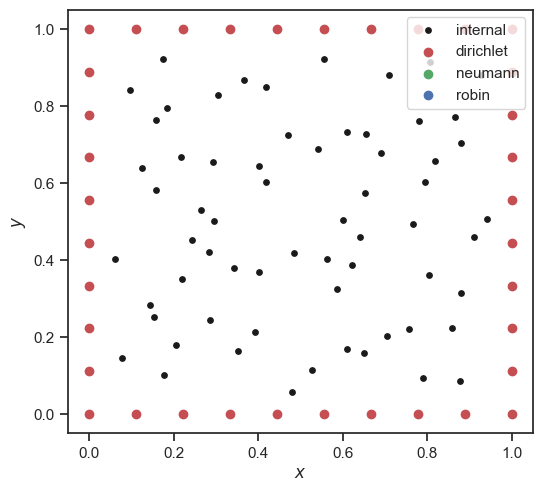

In [3]:
facet_types={"south":"d", "west":"d", "north":"d", "east":"d"}
cloud = SquareCloud(Nx=10, Ny=10, facet_types=facet_types, noise_key=key, support_size=1*11-1)

xy = cloud.sort_nodes_jnp() ## All points in the problem
cloud.visualize_cloud(figsize=(6,5.5));

In [4]:
class PINN(nn.Module):
    @nn.compact
    def __call__(self, x, y):
        in_data = jnp.stack([x, y], axis=-1)
        y = nn.Dense(50)(in_data)
        for _ in range(0, 3):
            y = nn.tanh(y)
            y = nn.Dense(50)(y)
        return nn.Dense(1)(y)[0]

def init_flax_params(net:nn.Module):
    init_data = jnp.ones((1,)), jnp.ones((1,))
    params = net.init(key, *init_data)
    # print(net.tabulate(key, *init_data, depth=8, console_kwargs={"force_jupyter":False}))
    print(net.tabulate(key, *init_data, depth=8))
    return params

pinn = PINN()
params = init_flax_params(pinn)

                    PINN Summary                    
┏━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ - float32[1]  │                        │
│         │ - float32[1]  │                        │
├─────────┼───────────────┼────────────────────────┤
│ Dense_0 │ float32[1,50] │ bias: float32[50]      │
│         │               │ kernel: float32[2,50]  │
│         │               │                        │
│         │               │ 150 (600 B)            │
├─────────┼───────────────┼────────────────────────┤
│ Dense_1 │ float32[1,50] │ bias: float32[50]      │
│         │               │ kernel: float32[50,50] │
│         │               │                        │
│         │               │ 2,550 (10.2 KB)        │
├─────────┼───────────────┼────────────────────────┤
│ Dense_2 │ float32[1,50] │ bias: float32[50]      │
│         │               │ kernel: float32[50,50] │
│         │               │                        │
│         │               │ 2,550 (10.2 KB)        │
├─────────┼───────────────┼────────────────────────┤
│ Dense_3 │ float32[1,50] │ bias: float32[50]      │
│         │               │ kernel: float32[50,50] │
│         │               │                        │
│         │               │ 2,550 (10.2 KB)        │
├─────────┼───────────────┼────────────────────────┤
│ Dense_4 │ float32[1,1]  │ bias: float32[1]       │
│         │               │ kernel: float32[50,1]  │
│         │               │                        │
│         │               │ 51 (204 B)             │
├─────────┼───────────────┼────────────────────────┤
│ PINN    │ float32[1]    │                        │
├─────────┼───────────────┼────────────────────────┤
│         │         Total │ 7,851 (31.4 KB)        │
└─────────┴───────────────┴────────────────────────┘
                                                    
         Total Parameters: 7,851 (31.4 KB)          

## Define boundary conditions

In [5]:
# Boundary data
north_nodes = [cloud.nodes[i] for i in cloud.facet_nodes["north"]]
xy_n = jnp.stack(north_nodes, axis=-1).T
u_n = jnp.sin(jnp.pi * xy_n[:, 0])

sew_nodes = [cloud.nodes[i] for i in cloud.facet_nodes["south"]+cloud.facet_nodes["east"]+cloud.facet_nodes["west"]]
xy_sew = jnp.stack(sew_nodes, axis=-1).T
u_sew = jnp.zeros_like(xy_sew[:, 0])

In [6]:
# Physical data inside of domain
internal_nodes = [cloud.nodes[i] for i in cloud.nodes.keys() if cloud.node_boundary_types[i]=="i"]
xy_i = jnp.stack(internal_nodes, axis=-1).T

## Training

In [7]:
@jax.grad
def u_x(x, y, params):
    return pinn.apply(params, x, y)

@jax.grad
def u_y(y, x, params):
    return pinn.apply(params, x, y)

@jax.grad
def u_xx(x, y, params):
    return u_x(x, y, params)

@jax.grad
def u_yy(y, x, params):
    return u_y(y, x, params)

## Vectorise everything that's usefull
vmapped_u = jax.vmap(pinn.apply, in_axes=(None, 0, 0), out_axes=0)
vmapped_u_xx = jax.vmap(u_xx, in_axes=(0, 0, None), out_axes=0)
vmapped_u_yy = jax.vmap(u_yy, in_axes=(0, 0, None), out_axes=0)

def residual(params, x, y):
    """ Physics-based loss function for Laplace equation """
    u_xx_ = vmapped_u_xx(x, y, params)
    u_yy_ = vmapped_u_yy(y, x, params)
    return u_xx_ + u_yy_

def loss_fn(params, xy_n, u_n, xy_sew, u_sew, xy_i):
    u_n_pred = vmapped_u(params, xy_n[:,0], xy_n[:,1])
    loss_n = optax.l2_loss(u_n_pred - u_n)        ## Data loss north

    u_sew_pred = vmapped_u(params, xy_sew[:,0], xy_sew[:,1])
    loss_sew = optax.l2_loss(u_sew_pred - u_sew)        ## Data loss south, west, and east

    res = residual(params, xy_i[:,0], xy_i[:,1])
    loss_i = optax.l2_loss(res)                    ## Residual loss

    eps_i, eps_n, eps_sew = 1e-1, 1e-0, 1e-0
    return eps_i*jnp.mean(loss_i) + eps_n*jnp.mean(loss_n) + eps_sew*jnp.mean(loss_sew)

grad_loss_fn = jax.grad(loss_fn)

@jax.jit
def train_step(state, xy_n, u_n, xy_sew, u_sew, xy_i):
    grads = grad_loss_fn(state.params, xy_n, u_n, xy_sew, u_sew, xy_i)
    state = state.apply_gradients(grads=grads)
    loss = loss_fn(state.params, xy_n, u_n, xy_sew, u_sew, xy_i)
    return state, loss

In [8]:
## Optimizer
scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-6, transition_steps=60001)
optimizer = optax.sgd(learning_rate=scheduler)

## Flax training state
state = train_state.TrainState.create(apply_fn=pinn.apply,
                                        params=params,
                                        tx=optimizer)

In [9]:
EPOCHS = 6001
batch_size = cloud.N // 10
history_loss = []   # data for plotting

if os.path.isfile("./temp/pinn_checkpoint_"+str(state.step)):
    print("Found existing network, loading & training from step", state.step)
    state = checkpoints.restore_checkpoint(ckpt_dir="./temp/", prefix="pinn_checkpoint_", target=state)
else:
    print("Training from scratch")

for epoch in range(EPOCHS+1):

    epoch_loss = 0
    for xy_i_batch in dataloader(xy_i, batch_size, key=key):
        state, loss = train_step(state, xy_n, u_n, xy_sew, u_sew, xy_i_batch)
        history_loss.append(loss)
        epoch_loss += loss

    if epoch<3 or epoch%1000==0:
        print("Epoch: %-5d                Loss: %.6f" % (epoch, epoch_loss))

checkpoints.save_checkpoint("./temp/", prefix="pinn_checkpoint_", target=state, step=state.step, overwrite=True)
print("Training done, saved network")

Training from scratch
Epoch: 0                    Loss: 1.085364
Epoch: 1                    Loss: 1.020158
Epoch: 2                    Loss: 0.971306
Epoch: 1000                 Loss: 0.437773
Epoch: 2000                 Loss: 0.353893
Epoch: 3000                 Loss: 0.300867
Epoch: 4000                 Loss: 0.266628
Epoch: 5000                 Loss: 0.243868
Epoch: 6000                 Loss: 0.227860
Training done, saved network


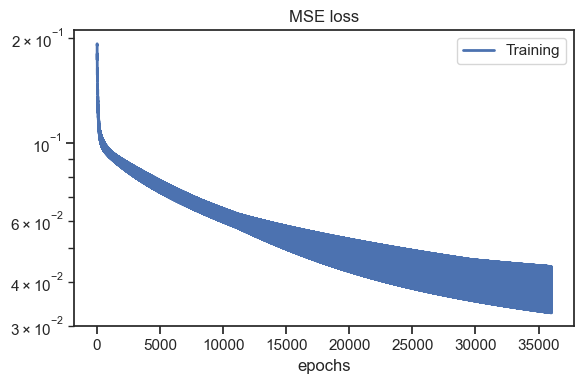

In [10]:
ax = plot(history_loss, label='Training', x_label='epochs', title='MSE loss', figsize=(6,4), y_scale="log")

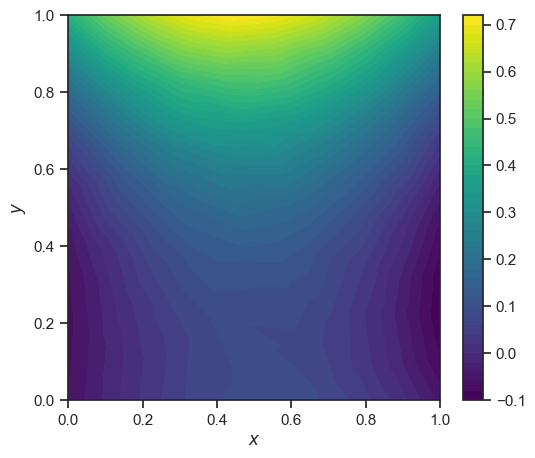

In [11]:
u_sol = vmapped_u(state.params, xy[:, 0], xy[:, 1])
cloud.visualize_field(u_sol, cmap="viridis", projection="2d", ax=None, figsize=(6,5));
# cloud.visualize_field(u_sol, cmap="viridis", projection="3d", ax=None, figsize=(10,10));

## Evaluation

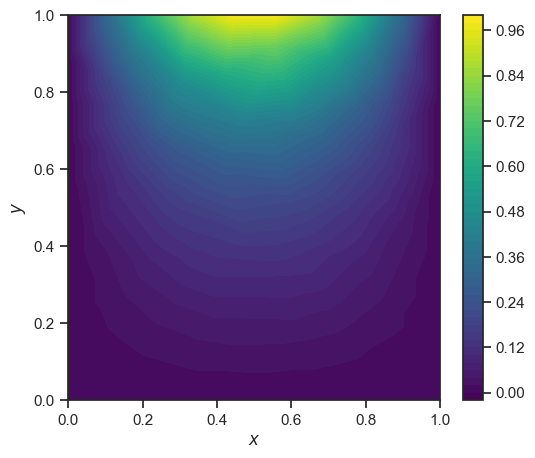

In [12]:
def laplace_exact_sol(x, y):
    # return jnp.cos(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1])
    return jnp.sin(jnp.pi*x)*jnp.sinh(jnp.pi*y) / jnp.sinh(jnp.pi)

exact_sol = laplace_exact_sol(xy[:, 0], xy[:,1])

# cloud.visualize_field(exact_sol, cmap="jet", projection="3d", ax=None, figsize=(10,10));
ax, img = cloud.visualize_field(exact_sol, cmap="viridis", projection="2d", ax=None, figsize=(6,5), levels=50);

## Findings
- Use batches for internal nodes, and impose boundary conditions at every batch


## Next steps
